# Multi $\kappa$ Scale Factor
This applies the scale factor theory to all simulations, through regression.

In [74]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_temp_adiabat
from isca_tools.thesis.adiabat_theory2 import get_approx_terms, get_scale_factor_theory
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [191]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
kappa_names.sort()
n_kappa = len(kappa_names)

ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
tau_lw = np.asarray(tau_lw)
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/8 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [246]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_exp = plt.cm.jet(np.linspace(0, 1, n_kappa))
ax_linewidth = plt.rcParams['axes.linewidth']
lw_publish = 1

labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

In [193]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [194]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_min = 70
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
lat = ds[0].lat[lat_use_ind].to_numpy()

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}        # error in z used in mse_mod approx
# Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

R_mod = get_theory_prefactor_terms(0, p_surface, pressure_ft_actual)[0]   # need to compute mse_mod

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season in ['summer', 'winter']:
            ds_nh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
            ds_sh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_season, ds_nh_season], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        z_av['median'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean'][j] = rh_use.mean(dim='lon_time')
        r_av['median'][j] = rh_use.median(dim='lon_time')
        mse_use_surf = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=ds_use.height.isel(pfull=ind_surf))
        mse_use_ft = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                         height=ds_use.height.isel(pfull=ind_ft))
        epsilon_use = mse_use_surf-mse_use_ft
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        epsilon_av['median'][j] = epsilon_use.median(dim='lon_time')
        mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-R_mod
                                          ) - epsilon_use
        mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                    height=0, c_p_const=c_p+R_mod)
        z_error_use = mse_mod_use - mse_mod_use_ft_approx
        z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
        z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')
        pbar.update(1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [195]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
# Really doesn't matter though but I think this method is simpler
# When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)

  0%|          | 0/11088 [00:00<?, ?it/s]

In [196]:
# Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
# In units of kJ/kg
epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=z_quant3[:, ind_surf]) -
                 moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))
# epsilon_av = {}
# for key in ['mean', 'median']:
#     epsilon_av[key] = (moist_static_energy(temp_av[key][:, ind_surf], r_av[key] * sphum_sat(temp_av[key][:, ind_surf], p_surface), height=0) -
#                        moist_static_energy(temp_av[key][:, ind_ft], sphum_sat(temp_av[key][:, ind_ft], pressure_ft_actual), z_av[key][:, ind_ft]))

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$, CAPE proxy, $\tilde{\epsilon}$ and error due to approximation of geopotential height, $\tilde{A}_z$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$\tilde{h}^{\dagger} = (c_p - R^{\dagger})\tilde{T}_s + L_v \tilde{q}_s - \epsilon = (c_p + R^{\dagger})\tilde{T}_{FT} + L_vq^*(\tilde{T}_{FT}, p_{FT})
 + \tilde{A}_z$

Where we use the computed average error due to z approximation, $\tilde{A}_z$ in this computation of $\tilde{T}_{FT}$.

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$
* $\tilde{A}_z = \overline{A}_z; \delta \tilde{A}_z = 0$

where the overline refers to the time-zonal mean value of that quantity.

In [197]:
av_use = 'mean'
# Recommended reference day
r_ref = np.zeros((n_kappa, n_lat))
r_ref[:] = r_av[av_use][0]        # no change in rh with warming, assumed for ref                    # use
epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
temp_ref = np.zeros((n_kappa, n_pressure, n_lat))
temp_ref[:, ind_surf] = temp_av[av_use][:, ind_surf]  # Have actual average surface temperature change with warming
z_approx_error_ref = np.zeros((n_kappa, n_lat))

# Amendment if want to use actual average day as reference in both climates
use_av_as_ref = False
if use_av_as_ref:
    r_ref[:] = r_av[av_use]
    epsilon_ref[:] = epsilon_av[av_use]
    z_approx_error_ref[:] = z_approx_error_av[av_use]

sphum_ref = r_ref * sphum_sat(temp_ref[:, ind_surf], p_surface)

# Given reference T_s, RH and epsilon, as well as error due to z approximation, T_FT directly from the modified MSE equation.
# This means that there is no approximation associated with geopotential height for the reference day
for i in range(n_kappa):
    for j in range(n_lat):
        # Include error due to z as modification of epsilon
        temp_ref[i, ind_ft, j] = get_temp_adiabat(temp_ref[i, ind_surf, j], sphum_ref[i, j],
                                                    p_surface, pressure_ft_actual, epsilon=epsilon_ref[i, j] + z_approx_error_ref[i, j])

In [198]:
# Plot showing how reference values differs from average
# If averaged used as ref for all simulations above, then av and ref below should match up exactly
show_plot = False
av_plot = av_use
fig, ax = plt.subplots(1,4, figsize=(4*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(lat, temp_av[av_plot][i, ind_surf], color=color_exp[i], label=labels_exp[i])
    ax[0].plot(lat, temp_ref[i, ind_surf], color=color_exp[i], linestyle=':')
    ax[1].plot(lat, temp_av[av_plot][i, ind_ft], color=color_exp[i], label=av_plot.capitalize() if i==0 else None)
    ax[1].plot(lat, temp_ref[i, ind_ft], color=color_exp[i], linestyle=':', label='Reference' if i==0 else None)
    ax[2].plot(lat, r_av[av_plot][i]*100, color=color_exp[i])
    ax[2].plot(lat, r_ref[i]*100, color=color_exp[i], linestyle=':')
    ax[3].plot(lat, epsilon_av[av_plot][i], color=color_exp[i])
    ax[3].plot(lat, epsilon_ref[i], color=color_exp[i], linestyle=':')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(lat[0], lat[-1])
ax[0].set_ylabel('$T_s$')
ax[1].set_ylabel('$T_{FT}$')
ax[2].set_ylabel('$r_s$')
ax[3].set_ylabel('$\epsilon$')
if show_plot:
    plt.show()
else:
    plt.close()

In [199]:
# delta_temp_quant_theory[0] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_kappa, n_lat, n_quant)) for method in
                           ['linear', 'non-linear']}
delta_temp_quant_theory_cont = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['temp_ft_change', 'r_change', 'epsilon_change',
                                                                            'temp_anom', 'r_anom', 'epsilon_anom']}
for method in delta_temp_quant_theory:
    for i in range(n_lat):
        for j in range(n_kappa-1):
            delta_temp_quant_theory[method][j+1, i], _, _, var = \
                    get_scale_factor_theory(temp_ref[j:j+2, ind_surf, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j:j+2, i], r_quant3[j:j+2, i],
                                                                   temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface,
                                                                   pressure_ft_actual, epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i])
            delta_temp_quant_theory[method][j+1, i] *= np.diff(temp_ref[j:j+2, ind_surf, i], axis=0)
            for key in delta_temp_quant_theory_cont:
                delta_temp_quant_theory_cont[key][j+1, i] = var[key] * np.diff(temp_ref[j:j+2, ind_surf, i], axis=0)
temp_surf_quant3_theory = {method: temp_quant3[0, ind_surf] + np.cumsum(delta_temp_quant_theory[method], axis=0) for method in delta_temp_quant_theory}
temp_surf_quant3_theory_cont = {key: np.cumsum(delta_temp_quant_theory_cont[key], axis=0) for key in delta_temp_quant_theory_cont}

In [200]:
# Sanity check that theory is working
show_plot = False
plot_lat_ind = -5
plot_quant_ind = -93

fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
ax.plot(temp_ref[:, ind_surf, plot_lat_ind], temp_quant3[:, ind_surf, plot_lat_ind, plot_quant_ind], color='k', marker='o', label='Simulated')
ax.plot(temp_ref[:, ind_surf, plot_lat_ind], temp_surf_quant3_theory['linear'][:, plot_lat_ind, plot_quant_ind], color='k', linestyle=':', label='Theory')
ax.set_xlabel('$\overline{T}_s$ [K]')
ax.set_ylabel(f'$T_s(x={quant_plot[plot_quant_ind]})$ [K]')
ax.legend()
ax.set_title('Lat={:.2f}$\degree$'.format(ds_all[0].lat[plot_lat_ind]))
if show_plot:
    plt.show()
else:
    plt.close()

In [201]:
def get_gradient(temp_quant, temp_ref, ref_ind, confidence=0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
            Temperature of given quantile for each experiment
        temp_ref: [n_exp]
            Reference temperature for each experiment
        ref_ind: int
            Regression line will go through (temp_ref[ref_ind], temp_quant[ref_ind])
            I.e. it sets the intercept
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient K/K
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x - temp_ref[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func, temp_ref, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_ref, param), z_score * param_std

In [248]:
# Consider 3 different groups of simulations: all; all below kappa=1. all above kappa=1
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1.5)[0], np.where(tau_lw>=1.5)[0]]
sf_tau_ref = [1.5, 1.5, 1.5]
n_sf = len(sf_tau_use)
sf_tau_ref_ind = [int(np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]) for i in range(n_sf)]
sf_labels = [f'${tau_lw[sf_tau_use[0]].min()} \leq \kappa \leq {tau_lw[sf_tau_use[0]].max()}$',
             f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$',
             f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
confidence = 0.9        # confidence bound for error bar

scaling_factor = np.zeros((n_sf, n_lat, n_quant))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant))
scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant)) for method in delta_temp_quant_theory}
scaling_factor_theory_cont = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_cont}

with tqdm(total=n_sf*n_lat*n_quant, position=0, leave=True) as pbar:
    for i in range(n_sf):
        for j in range(n_quant):
            # The theory predicts median change but not mean hence I use median rather than mean.
            # This means can get theoretical scale factor rather than using simulated mean.
            # This means x=50 will correspond to y=1 in all plots below.
            # Straight line through the ref point
            for k in range(n_lat):
                scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                         temp_ref[sf_tau_use[i], ind_surf, k], sf_tau_ref_ind[i],
                                                                                         confidence)
                for method in scaling_factor_theory:
                    scaling_factor_theory[method][i, k, j] = get_gradient(temp_surf_quant3_theory[method][sf_tau_use[i], k, j],
                                                                          temp_ref[sf_tau_use[i], ind_surf, k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                for key in scaling_factor_theory_cont:
                    scaling_factor_theory_cont[key][i, k, j] = get_gradient(temp_surf_quant3_theory_cont[key][sf_tau_use[i], k, j],
                                                                          temp_ref[sf_tau_use[i], ind_surf, k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                pbar.update(1)

  0%|          | 0/4158 [00:00<?, ?it/s]

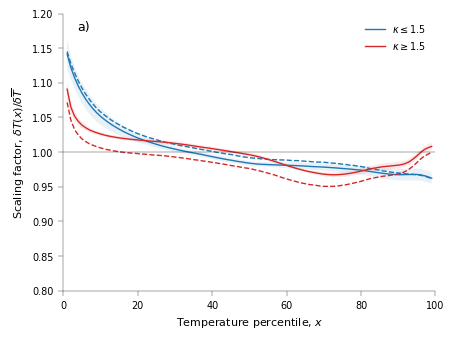

In [279]:
save_sf_theory_fig = True
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
for i in range(1, 3):
    ax.plot(quant_plot, np.average(scaling_factor[i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
            label='Simulated' if is_land_data else sf_labels[i], lw=lw_publish)
    ax.plot(quant_plot, np.average(scaling_factor_theory['linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
        linestyle='--', lw=lw_publish, label='Theory' if (is_land_data and i==1) else None)
    ax.fill_between(quant_plot, np.average(scaling_factor[i]-scaling_factor_error[i], axis=0, weights=lat_weights),
                    np.average(scaling_factor[i]+scaling_factor_error[i], axis=0, weights=lat_weights),
                    fc=default_colors[0+3*(i-1)], alpha=0.1)

ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.set_xlim(0,100)
ax.set_ylim(0.8,1.2)
ax.set_xlabel('Temperature percentile, $x$')
ax.legend()
if is_land_data:
    label_subplots(fig, ax, ['b)'])
else:
    ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    label_subplots(fig, ax)
plt.show()
if save_sf_theory_fig:
    isca_tools.savefig(fig, 'sf_theory', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [275]:
plot_sf_ind_use = 0
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
ax.plot(quant_plot, np.average(scaling_factor[plot_sf_ind_use], axis=0, weights=lat_weights), color='b', label='Simulated')
ax.plot(quant_plot, np.average(scaling_factor_theory['linear'][plot_sf_ind_use], axis=0, weights=lat_weights), color='k',
        linestyle='--', label=f'Theory')
# Add error
ax.fill_between(quant_plot, np.average(scaling_factor[plot_sf_ind_use]-scaling_factor_error[plot_sf_ind_use], axis=0, weights=lat_weights),
                np.average(scaling_factor[plot_sf_ind_use]+scaling_factor_error[plot_sf_ind_use], axis=0, weights=lat_weights), fc='b', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if show_plot:
    plt.show()
else:
    plt.close()

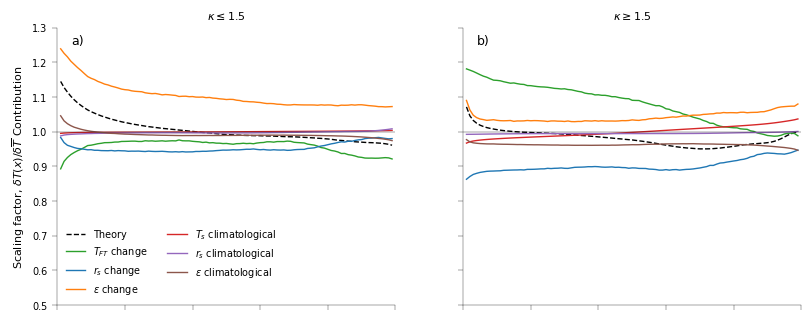

In [269]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'epsilon_anom': default_colors[5],
               'epsilon_change': default_colors[1]}
labels_cont = {'temp_ft_change': '$T_{FT}$ change', 'r_change': '$r_s$ change', 'epsilon_change': '$\epsilon$ change',
               'temp_anom': '$T_s$ climatological', 'r_anom': '$r_s$ climatological', 'epsilon_anom': '$\epsilon$ climatological'}

save_sf_breakdown_fig = True
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharey=True, sharex=True)
for i in range(1, 3):
    ax[i-1].plot(quant_plot, np.average(scaling_factor_theory['linear'][i], axis=0, weights=lat_weights),
                 color='k', lw=1, linestyle='--', label='Theory')
    for key in scaling_factor_theory_cont:
        ax[i-1].plot(quant_plot, (0 if 'ft' in key else 1)+np.average(scaling_factor_theory_cont[key][i], axis=0, weights=lat_weights),
                color=colors_cont[key], lw=lw_publish, label=labels_cont[key])
    ax[i-1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlim(0,100)
if is_land_data:
    label_subplots(fig, ax, ['c)', 'd)'])
    ax[0].set_xlabel('Temperature percentile, $x$')
    ax[1].set_xlabel('Temperature percentile, $x$')
else:
    label_subplots(fig, ax)
    ax[0].set_xticklabels([])
    ax[0].legend(ncol=2)
    ax[0].set_title(sf_labels[1])
    ax[1].set_title(sf_labels[2])
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$ Contribution')
ax[0].set_ylim(0.5, 1.3)
plt.show()
if save_sf_breakdown_fig:
    isca_tools.savefig(fig, 'sf_breakdown', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [276]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
for key in scaling_factor_theory_cont:
    ax.plot(quant_plot, np.average(scaling_factor_theory_cont[key][2]-scaling_factor_theory_cont[key][1], axis=0, weights=lat_weights),
               label=key, color=colors_cont[key])
ax.set_xlim(0,100)
ax.hlines(0, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend(ncol=2)
ax.set_xlabel('Temperature percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()